In [318]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

# 1. Contador de dinero interactivo

El objetivo es estimar la cantidad de dinero presente en una imagen identificando las monedas que contiene. Se combina información del área de cada moneda con una selección interactiva de referencia para establecer un factor de escala.

La imagen se carga, se convierte a escala de grises y se aplica un umbral binario inverso mediante el método de Otsu para separar el fondo blanco de las monedas.

Se aplica un filtro de mediana para reducir el ruido sin eliminar los bordes de las monedas. A continuación, un filtro gaussiano suaviza pequeñas variaciones y transiciones, evitando que las sombras generen contornos adicionales.

Finalmente, se obtienen los contornos con `cv2.findContours()`, descartando aquellos con área demasiado pequeña. La imagen resultante muestra los contornos detectados.

Una vez se muestra la selección interactiva el usuario selecciona una moneda de referencia (una moneda de 50 céntimos) haciendo clic sobre ella en la imagen. Esto permite calcular un factor de escala que relaciona el área de la moneda detectada en la imagen con el área real de la moneda en milímetros cuadrados.

Ahora para cada contorno detectado se calcula su área relativa utilizando el factor de escala. Se asigna a cada contorno la moneda cuyo área teórica se aproxima más a la medida calculada. La suma de todas las monedas proporciona la cuenta total de dinero en la imagen, que se muestra junto con la visualización de las monedas.

In [320]:
def resize_image(image, max_size):
    h, w = image.shape[:2]
    
    if h > w:
        scale_factor = max_size / h
    else:
        scale_factor = max_size / w
    
    new_h = int(h * scale_factor)
    new_w = int(w * scale_factor)
    
    return cv2.resize(image, (new_w, new_h))

coin_diameters: dict[int, float] = {
    200: 25.75,
    100: 23.25,
    50: 24.25,
    20: 22.25,
    10: 19.75,
    5: 21.25,
    2: 18.75,
    1: 16.26
}

coin_areas: dict[int, float] = {
    coin: math.pi * (diameter / 2) ** 2
        for coin, diameter in coin_diameters.items()
}

img = cv2.cvtColor(resize_image(cv2.imread('images/coins.jpg'), 900), cv2.COLOR_BGR2RGB)

_, img_g = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
img_g = cv2.medianBlur(img_g, 11)
img_g = cv2.GaussianBlur(img_g, (3, 3), 5)

contours, hierarchy = cv2.findContours(
    img_g, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE
)
contours = tuple(filter(lambda c: cv2.contourArea(c) > 100, contours))

cv2.drawContours(img, contours, -1, (0,255,0), 3)

can_close = False

def mouse_callback(event, x, y, flags, param):
    global can_close
    closest_countour = (float('inf'), None)
    if event == cv2.EVENT_LBUTTONDOWN:
        pixel = (x, y)
        for c in contours:
            (center, axes, orientation) = cv2.fitEllipse(c)
            distance = cv2.norm(pixel, center, cv2.NORM_L2)
            if (distance < closest_countour[0]):
                closest_countour = (distance, c)

        m = cv2.contourArea(closest_countour[1]) / coin_areas[50]
        total_cents: int = 0
        for c in contours:
            area = cv2.contourArea(c)
            rel_area = area / m
            closest_coin_type = min(coin_areas.keys(), key=lambda k: abs(coin_areas[k] - rel_area))
            total_cents += closest_coin_type
        
        print(f"Cuenta total: {total_cents / 100} €")
        can_close = True


cv2.putText(
    img,
    "Selecciona una moneda de 50 centimos",
    (30, 20),
    cv2.FONT_HERSHEY_SIMPLEX,
    0.5,
    (255, 0 ,0)
)
cv2.imshow('coins', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
cv2.setMouseCallback('coins', mouse_callback)
while True:
    key_code = cv2.waitKey(200)
    if key_code == 27:
        break
    if can_close:
        break
cv2.destroyAllWindows()


Cuenta total: 1.04 €


# 2. Clasificación de microplásticos

Primero es necesario extraer características geométricas y visuales de las partículas presentes en las imágenes de partida y generar vectores representativos de cada categoría de microplástico. Estos vectores servirán como referencia para identificar partículas en imágenes nuevas.

Se cargan las tres imágenes completas correspondientes a cada tipo de microplástico: fragmentos (FRA), pellets (PEL) y alquitrán (TAR). Cada imagen se convierte a escala de grises y se aplica un filtro de mediana para reducir el ruido. Posteriormente, se realiza un umbral adaptativo binario inverso para separar las partículas del fondo.

Para reforzar los bordes de las partículas, se aplica una dilatación morfológica utilizando un kernel elíptico. Esta operación intenta continuar el borde para unirlo.

Se obtiene el conjunto de contornos, filtrando aquellos que no cumplen criterios mínimos y máximos de área, así como un límite en la relación área/perímetro al cuadrado.

Para cada contorno, se ajusta una elipse mediante `cv2.fitEllipse()`, obteniendo su centro, ejes y orientación. A partir de esta información y de los valores HSV del pixel central, se calculan los siguientes descriptores: relación área/perímetro al cuadrado, relación entre eje mayor y eje menor y valores de color HSV del centro del contorno.

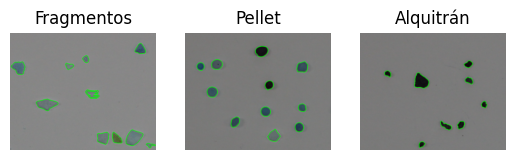

In [ ]:
from cv2 import Mat


imgF = cv2.imread('images/FRA.png')
imgP = cv2.imread('images/PEL.png')
imgT = cv2.imread('images/TAR.png')

def extract_contours(img: Mat, min_area: int, max_area: int, max_area_per_perimeter_squared):
    contours, hierarchy = cv2.findContours(
        img, 
        cv2.RETR_EXTERNAL, 
        cv2.CHAIN_APPROX_SIMPLE
    )

    contours = tuple(filter(
        lambda c: cv2.contourArea(c) > min_area and cv2.contourArea(c) < max_area, contours
    ))

    return tuple(filter(
        lambda c: (cv2.contourArea(c) / cv2.arcLength(c, True) ** 2) < max_area_per_perimeter_squared, contours
    ))

imgF_g = cv2.cvtColor(imgF, cv2.COLOR_BGR2GRAY)
imgP_g = cv2.cvtColor(imgP, cv2.COLOR_BGR2GRAY)
imgT_g = cv2.cvtColor(imgT, cv2.COLOR_BGR2GRAY)

imgF_g = cv2.medianBlur(imgF_g, 11)
imgF_g = cv2.adaptiveThreshold(
    imgF_g,
    255,
    cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY_INV,
    11,
    2
)
imgP_g = cv2.medianBlur(imgP_g, 11)
imgP_g = cv2.adaptiveThreshold(
    imgP_g,
    255,
    cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY_INV,
    11,
    2
)
imgT_g = cv2.medianBlur(imgT_g, 11)
imgT_g = cv2.adaptiveThreshold(
    imgT_g,
    255,
    cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY_INV,
    11,
    2
)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
imgF_g = cv2.dilate(imgF_g, kernel, iterations=1)
imgP_g = cv2.dilate(imgP_g, kernel, iterations=1)
imgT_g = cv2.dilate(imgT_g, kernel, iterations=1)

contoursF = extract_contours(imgF_g, 1000, 30000, 0.07)
contoursP = extract_contours(imgP_g, 1000, 30000, 0.07)
contoursT = extract_contours(imgT_g, 1000, 30000, 0.07)

cv2.drawContours(imgF, contoursF, -1, (0,255,0), 3)
cv2.drawContours(imgP, contoursP, -1, (0,255,0), 3)
cv2.drawContours(imgT, contoursT, -1, (0,255,0), 3)

plt.subplot(131)
plt.axis("off")
plt.imshow(imgF) 
plt.title('Fragmentos')
plt.subplot(132)
plt.axis("off")
plt.imshow(imgP) 
plt.title('Pellet')
plt.subplot(133)
plt.axis("off")
plt.imshow(imgT) 
plt.title('Alquitrán')


# Extraer vectores de caracteristicas de cada contorno
imgF = cv2.cvtColor(imgF, cv2.COLOR_BGR2HSV)
imgP = cv2.cvtColor(imgP, cv2.COLOR_BGR2HSV)
imgT = cv2.cvtColor(imgT, cv2.COLOR_BGR2HSV)

features: dict[tuple[float], str] = dict()

def add_features(features, category, contours, img_hsv) -> None:
    vectors = []

    for c in contours:
        (x, y), (Ma, ma), orientation = cv2.fitEllipse(c)
        (x, y) = int(x), int(y)
        h, s, v = img_hsv[y, x]
        area_p_perimeter_squared = cv2.contourArea(c) / cv2.arcLength(c, True) ** 2
        Ma_p_ma = Ma / ma

        #features[(area_p_perimeter_squared, Ma_p_ma, float(h), float(s), float(v))] = category
        vectors.append((area_p_perimeter_squared, Ma_p_ma, float(h), float(s), float(v)))
    
    mean = np.mean(vectors, axis=0)
    features[tuple(float(x) for x in mean)] = category

add_features(features, 'FRA', contoursF, imgF)
add_features(features, 'PEL', contoursP, imgP)
add_features(features, 'TAR', contoursT, imgT)


Para extraer los contornos de las partículas en la imagen de test, se convierte la imagen a escala de grises y se aplica un filtro de mediana para reducir el ruido. Se combinan distintos umbralizados adaptativos y globales junto con operadores de detección de bordes (Sobel, Canny y Laplaciano) para resaltar los contornos de los objetos.

Las máscaras resultantes se combinan para generar una máscara final que intenta aislar los contornos de los microplásticos.

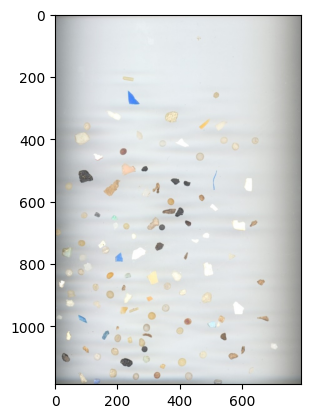

Text(0.5, 1.0, 'Sobel')

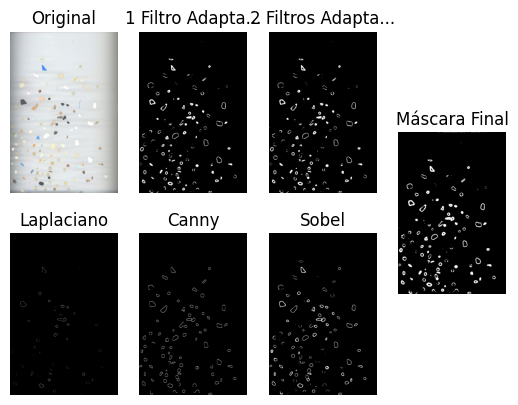

In [287]:
img = cv2.cvtColor(cv2.imread('MPs_test.jpg'), cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()

img_g = cv2.medianBlur(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), 11)
img_b = cv2.adaptiveThreshold(
    img_g,
    20,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    21,
    4
)
_, img_b = cv2.threshold(img_b, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
img_d = cv2.adaptiveThreshold(
    img_g,
    20,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    15,
    4
)
_, img_d = cv2.threshold(img_d, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
img_d = cv2.bitwise_or(img_b, img_d)

grad_x = cv2.Sobel(img_g, cv2.CV_64F, 1, 0, ksize=3)
grad_y = cv2.Sobel(img_g, cv2.CV_64F, 0, 1, ksize=3)
grad = cv2.magnitude(grad_x, grad_y)
grad = cv2.convertScaleAbs(grad)
_, grad = cv2.threshold(grad, 40, 255, cv2.THRESH_BINARY)

laplacian = cv2.Laplacian(img_g, cv2.CV_8U)
_, laplacian = cv2.threshold(laplacian, 20, 255, cv2.THRESH_BINARY)

canny = cv2.Canny(img_g, 30, 80)
canny = cv2.dilate(canny, (3, 3))
mask = cv2.bitwise_or(img_d, canny)
mask = cv2.bitwise_or(mask, grad)
mask = cv2.bitwise_or(mask, laplacian)

plt.subplot(241)
plt.axis("off")
plt.imshow(img) 
plt.title('Original')
plt.subplot(242)
plt.axis("off")
plt.imshow(img_b, cmap='gray') 
plt.title('1 Filtro Adapta...')
plt.subplot(243)
plt.axis("off")
plt.imshow(img_d, cmap='gray') 
plt.title('2 Filtros Adapta...')
plt.subplot(144)
plt.axis("off")
plt.imshow(mask, cmap='gray')
plt.title('Máscara Final')
plt.subplot(245)
plt.axis("off")
plt.imshow(laplacian, cmap='gray')
plt.title('Laplaciano')
plt.subplot(246)
plt.axis("off")
plt.imshow(canny, cmap='gray')
plt.title('Canny')
plt.subplot(247)
plt.axis("off")
plt.imshow(grad, cmap='gray') 
plt.title('Sobel')

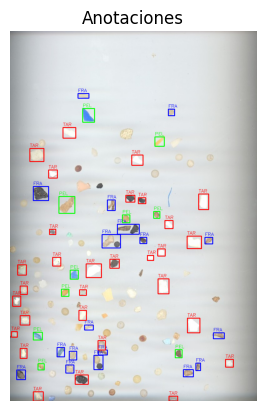

In [ ]:
# clasificar los contornos en su categoria
img = cv2.cvtColor(cv2.imread('MPs_test.jpg'), cv2.COLOR_BGR2RGB)
colores = {
    "FRA": (0, 0, 255),   # Rojo 
    "PEL": (0, 255, 0),   # Verde
    "TAR": (255, 0, 0)    # Azul
}

weights = np.array((100.0, 100.0, 0.1, 1.0, 0.1), dtype=np.float64)

contours = extract_contours(mask, 200, 3000, 0.07)
img_HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

tags = []

for c in contours:
    (x, y), (Ma, ma), orientation = cv2.fitEllipse(c)
    (x, y) = int(x), int(y)
    h, s, v = img_HSV[y, x]
    area_p_perimeter_squared = cv2.contourArea(c) / cv2.arcLength(c, True) ** 2
    Ma_p_ma = Ma / ma

    vector = np.array((area_p_perimeter_squared, Ma_p_ma, float(h), float(s), float(v)), dtype=np.float64)

    closest_cat = (float('inf'), None)

    for k, v in features.items():
        dist = cv2.norm(vector * weights, np.array(k, dtype=np.float64) * weights, cv2.NORM_L1)
        if dist < closest_cat[0]:
            closest_cat = (dist, v)
    
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(img, (x, y), (x + w, y + h), colores[closest_cat[1]], 2)
    cv2.putText(img, closest_cat[1], (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colores[closest_cat[1]], 1)
    tags.append(((x + w / 2, y + h / 2), closest_cat[1]))

plt.imshow(img)
plt.axis("off")
plt.title('Anotaciones')
plt.show()

Text(0.5, 1.0, 'Anotaciones CSV')

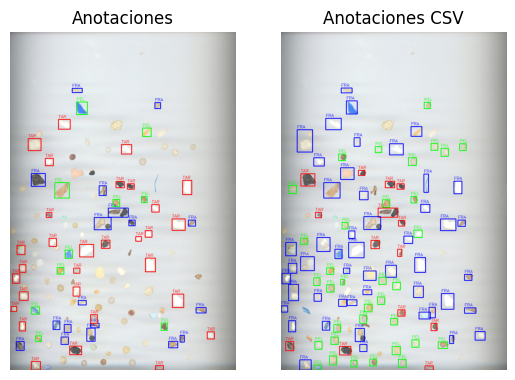

In [ ]:
import csv


img_orig = cv2.cvtColor(cv2.imread('MPs_test.jpg'), cv2.COLOR_BGR2RGB)
csv_file = "MPs_test_bbs.csv"

tags_orig = []

with open(csv_file, newline="") as file:
    reader = csv.DictReader(file)
    for row in reader:
        etiqueta = row["label"]
        x_min, y_min, x_max, y_max = map(int, [row["x_min"], row["y_min"], row["x_max"], row["y_max"]])
        color = colores.get(etiqueta, (0, 0, 0))
        cv2.rectangle(img_orig, (x_min, y_min), (x_max, y_max), color, 2)
        cv2.putText(img_orig, etiqueta, (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
        tags_orig.append(((x_min + (x_max - x_min) / 2, y_min + (y_max - y_min) / 2), etiqueta))

plt.subplot(121)
plt.axis("off")
plt.imshow(img) 
plt.title('Anotaciones')
plt.subplot(122)
plt.axis("off")
plt.imshow(img_orig) 
plt.title('Anotaciones CSV')

Se obtienen las etiquetas de las partículas tanto de nuestras anotaciones como del archivo CSV de referencia. Cada conjunto de etiquetas incluye la posición y la categoría de cada microplástico en la imagen de test.

La comparación visual muestra que nuestras anotaciones no coinciden completamente con las del CSV, indicando que la detección automática realizada presenta errores y omite algunas partículas.

Se calcula la matriz de confusión comparando las etiquetas reales del CSV con las predicciones obtenidas a partir de nuestras anotaciones. Cada fila representa la clase verdadera y cada columna la clase predicha, incluyendo una categoría adicional "FALTANTE" para partículas que no fueron detectadas. Esto permite visualizar de manera clara qué partículas se clasifican correctamente y cuáles se asignan a clases incorrectas o no se detectan.

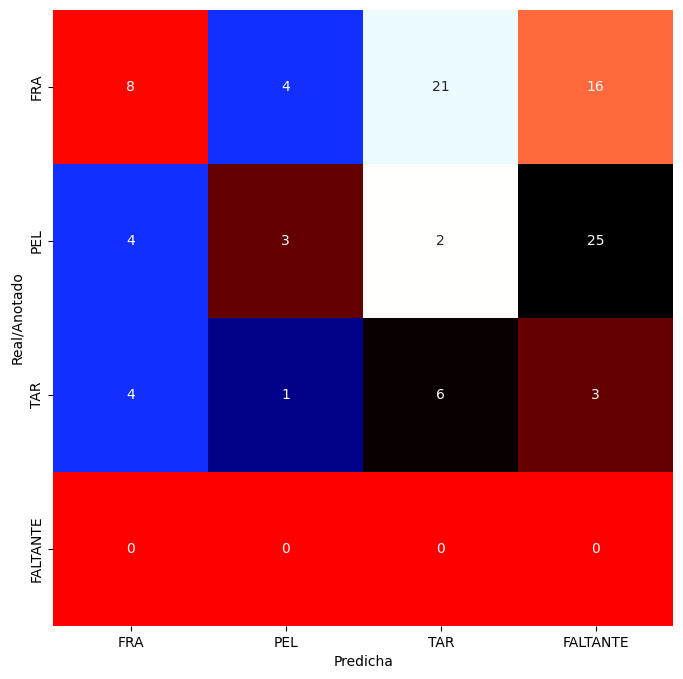

Accuracy = 17.53%
Precision = 41.39%
Recall = 17.53%
F1 Score = 21.47%


In [314]:
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

categories = ['FRA', 'PEL', 'TAR']
missing_label = 'FALTANTE'

y_true = []
y_pred = []

for (cx, cy), label_true in tags_orig:
    closest_pred = missing_label
    min_dist = float('inf')
    for (px, py), label_pred in tags:
        dist = np.hypot(cx - px, cy - py)
        if dist < min_dist and dist < 20:
            min_dist = dist
            closest_pred = label_pred
    y_true.append(label_true)
    y_pred.append(closest_pred)

all_labels = categories + [missing_label]

conf_matrix = confusion_matrix(y_true, y_pred, labels=all_labels)

plt.figure(figsize=(8,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False, cmap='flag',
            xticklabels=all_labels, yticklabels=all_labels)
plt.xlabel("Predicha")
plt.ylabel("Real/Anotado")
plt.show()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1score = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Accuracy = {accuracy * 100:.2f}%")
print(f"Precision = {precision * 100:.2f}%")
print(f"Recall = {recall * 100:.2f}%")
print(f"F1 Score = {f1score * 100:.2f}%")

A partir de la matriz de confusión se calculan algunas métricas como la exactitud, precisión, exhaustividad y puntuación F1. Los resultados obtenidos indican que no se es capaz de clasificar correctamente las partículas de plástico: Exactitud = 17,53%, Precisión = 41,39%, Exhaustividad = 17,53% y Puntuación F1 = 21,47%. Apenas logra se identificar correctamente las partículas y muchas detecciones son erróneas o están ausentes.

Por lo tanto, es necesario mejorar el proceso de clasificación de características. Puede ser útil ajustar los pesos de las distintas propiedades de los contornos y explorar un método más preciso para la obtención de los contornos de la imagen a procesar.